# Dual Rate Spring System

A dual rate system consists of two coil springs in series (main and tender) and a crossover ring which dictates the transition between the equivalent rate of the two springs to the higher spring rate of the main spring. The main point of using dual rate systems is to achieve better ride control without bottoming the suspension on jumps. 

The equivalent spring rate is given by 
$
\begin{align}
k_{eq} = \frac{k_{main} k_{tender}}{k_{main}+k_{tender}}
\bigg[  \frac{\mbox{lb}}{\mbox{in}} \bigg]
\end{align}
$
where:

$k_{main}$ is the main spring rate [lb/in]

$k_{tender}$ is the tender spring rate [lb/in]

First, let's load input data to rollout some calculations:

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

g = 9.81

spring_input = pd.read_excel('springs_input.xlsx', header=1)
vehicle_input = pd.read_excel('vehicle_input.xlsx', header = 1, dtype=np.float64)

spring_input['k_eq'] = round((spring_input['k_main']*spring_input['k_tender']) / 
                             (spring_input['k_main']+spring_input['k_tender']),2)

lb_in2N_mm = 0.017858*9.81

for convert_to_SI in ['k_tender', 'k_main', 'k_eq']:
    spring_input[convert_to_SI + str('_SI')] = round(spring_input[convert_to_SI]*lb_in2N_mm,2)

spring_input

,setup,k_main,L_main_free,L_main_stack,k_tender,L_tender_free,L_tender_stack,crossover_ring,preload,k_eq,k_tender_SI,k_main_SI,k_eq_SI
0,1,300,100,60,250,100,50,10,20,136.36,43.8,52.56,23.89
1,2,300,100,60,250,100,50,20,10,136.36,43.8,52.56,23.89
2,3,300,100,60,250,100,50,30,30,136.36,43.8,52.56,23.89


The force and the system displacement are related by the equation:

$
\begin{align}
F_{s} = \left \{ \begin{matrix} k_{eq}x, & \mbox{if } x \le x_{crossover} \\ 
k_{main}x, & \mbox{if } x > x_{crossover} \end{matrix} \right.
\end{align}
$

Where:

- $F_{s}$ is the spring froce [N];
- $x$ is the displacement of the system [mm];
- $x_{crossover}$ is the crossover distance [mm].

$x_{crossover}$ occurs when the slider hits the crossover ring and from that point only the main spring is compressed. This point is where the force of the equivalent system compresses the tender spring by the amount of the crossover ring distance set with the damper at full rebound.


$
\begin{align}
F_{crossover} = k_{tender}x_{crossover\_ring}
\end{align}
$

Thus, the $x_{crossover}$ is given by the equation:

$
\begin{align}
x_{crossover} = \frac{F_{crossover}}{k_{eq}} = \frac{k_{tender}x_{crossover\_ring}}{k_{eq}}
\end{align}
$


18
x_to_stack =  0    42.576104
dtype: float64
0    8.333333
dtype: float64
36
x_to_stack =  1    38.788052
dtype: float64
1    16.666667
dtype: float64
55
x_to_stack =  2    21.364155
dtype: float64
2    25.0
dtype: float64
end loop


,displacement,spring_force,setup
0,0.0,477.0,1
1,0.1,479.3,1
2,0.2,481.6,1
3,0.3,483.9,1
4,0.4,486.2,1


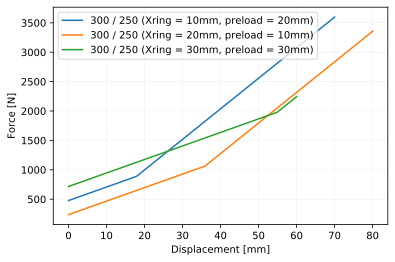

In [121]:
spring_system = pd.DataFrame()

for setup in range(1, len(spring_input) + 1):
    data_temp = spring_input[spring_input['setup'] == setup]
    df = pd.DataFrame()
    spring_force = []

    displacement_step = 0.1

    x_crossover =  int(data_temp['k_tender_SI'] * data_temp['crossover_ring'] / data_temp['k_eq_SI'])
    print(x_crossover)
    
    L_main = data_temp['L_main_free'] - data_temp['L_main_stack']
    L_tender = data_temp['L_tender_free'] - data_temp['L_tender_stack']
    
    
    F_preload = data_temp['k_eq_SI']*data_temp['preload']
    # compression of the main spring due to preload
    x_preload_main = F_preload / data_temp['k_main_SI'] 
    # compression of the main spring until it hits the crossover ring
    x_crossover_main = data_temp['k_tender_SI'] * data_temp['crossover_ring'] / data_temp['k_main_SI']
    # length remaining until stack length of the main spring
    x_to_stack = data_temp['L_main_stack'] - (x_preload_main + x_crossover_main)
    print('x_to_stack = ', x_to_stack)
    
    damper_length_ride_height = (float(vehicle_input['L_damper_extended']) 
                             - (W_rear * g - F_preload) / (2 * data_temp['k_eq_SI']))
    
    print(x_crossover_main)
    x_preload_tender = F_preload / data_temp['k_tender_SI']
    
    ##print(F_preload, x_preload_main, x_preload_tender, data_temp['preload'])

    df['displacement'] = np.arange(0, int((L_main - x_preload_main + L_tender - x_preload_tender)) 
                                    + displacement_step , displacement_step)
    ########################## 
    #REVISAR o calculo da precarga no spring_force... F_preload
    
    for displacement in df['displacement']:
        if displacement < x_crossover:
            spring_force.append(displacement*int(data_temp['k_eq_SI'])+ int(F_preload))
        else:
            spring_force.append(spring_force[-1] + displacement_step*int(data_temp['k_main_SI'] 
                                                                        ))
    ########################

    df['spring_force'] = spring_force
    df['setup'] = setup
    spring_system = spring_system.append(df)
    
    
print('end loop')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(1,1,1)

for setup in range(1, len(spring_input) + 1):

    ax.plot('displacement', 'spring_force', data = spring_system[spring_system['setup']==setup], 
            label = (str(int(spring_input.loc[spring_input.setup == setup]['k_main']))) + 
            ' / ' + str(int(spring_input.loc[spring_input.setup == setup]['k_tender'])) + 
            ' (Xring = ' + str(int(spring_input.loc[spring_input.setup == setup]['crossover_ring'])) + 
            'mm, preload = ' + str(int(spring_input.loc[spring_input.setup == setup]['preload'])) + 'mm)')

ax.legend()
ax.set_xlabel('Displacement [mm]')
ax.set_ylabel('Force [N]')
ax.grid(linestyle=':', linewidth=0.3)


spring_system.head()

In [23]:
vehicle_input

,L_wheelbase,L_front_track,L_rear_track,h_cg,W_total,W_front_unsprung,W_rear_unsprung,rear_mass_distribution,L_damper_extended,L_damper_compressed
0,2900,1850,1850,800,950,50,60,0.71,950,650


In [125]:
stroke = vehicle_input['L_damper_extended'] - vehicle_input['L_damper_compressed']


damper_length_ride_height = 850

stroke_ride_height = stroke - (vehicle_input['L_damper_extended'] - damper_length_ride_height)

stroke_ride_height



0    200.0
dtype: float64

## coil_bind function

Inputs:
- $K_{main}$ main spring rate [lb/in]
- $L_{main\_free}$ main spring free length [mm]
- $L_{main\_stack}$ main spring stack length [mm]


- $K_{tender}$ tender spring rate [lb/in]
- $L_{tender\_free}$ tender spring free length [mm]
- $L_{tender\_stack}$ tender spring stack length [mm]


- $L_{damper\_extended}$ extended length with limit straps race ready [mm]
- $L_{damper\_compressed}$ compressed length without bump rubber as spec sheet [mm]
- $L_{damper\_RH}$ damper length at ride height race ready [mm]


- $x_{spring\_preload}$ main spring free length [mm]

Ouputs:
- $x_{min\_crossover\_ring}$ minimum crossover ring clearance at ride height to avoid main spring coil bind [mm]
- $L_{main\_RH}$ main spring length at ride height [mm]


$
L_{main\_RH} = L_{main\_free} - \frac{K_{eq}}{K_{main}}(L_{damper\_extended} - L_{damper\_RH}) - 
\frac{K_{eq}}{K_{main}}(x_{spring\_preload})
$

$
x_{min\_crossover\_ring} = \frac{K_{eq}}{K_{main}}(L_{main\_RH} - L_{main\_stack})
$



In [154]:
k_main = spring_input['k_main']
#L_main_free = spring_input['L_main_free']
L_main_free = 500
L_main_stack = spring_input['L_main_stack']

k_tender = spring_input['k_tender']
L_tender_free = spring_input['L_tender_free']
L_tender_stack = spring_input['L_tender_stack']

x_spring_preload = spring_input['preload']

L_damper_extended = vehicle_input['L_damper_extended']
L_damper_compressed = vehicle_input['L_damper_compressed']
L_damper_ride_height = vehicle_input['L_damper_ride_height']



k_eq = k_main*k_tender / (k_main + k_tender)


L_main_ride_height = (L_main_free - (k_eq/k_main)*(L_damper_extended - L_damper_ride_height) 
                      - (k_eq/k_main)*x_spring_preload)


x_min_crossover_ring = (k_eq/k_main)*(L_main_ride_height - L_main_stack)

In [217]:
df = pd.read_excel('test.xlsx', index_col=0, header=None, usecols = "A,C:AA", skiprows=1).transpose()
df

,k_main,L_main_free,L_main_stack,k_tender,L_tender_free,L_tender_stack,crossover_ring,preload
2,300,100,60,250,100,50,10,20
3,300,100,60,250,100,50,20,10
4,300,100,60,250,100,50,30,30


In [194]:
spring_input['setup']

0    1
1    2
2    3
Name: setup, dtype: int64

# Longitudinal Load Transfer

In [6]:
vehicle_input = pd.read_excel('vehicle_input.xlsx', header = 1)

vehicle_input

,L_wheelbase,L_front_track,L_rear_track,h_cg,W_total,W_front_unsprung,W_rear_unsprung,rear_mass_distribution
0,2900,1850,1850,800,950,50,50,0.71


Longitudinal load transfer $\Delta W_x$ is given by:

$
\begin{align}
\Delta W_x = ma_x \frac{h_{cg}}{L_{wb}}
\end{align}
$

where,

- $m$ is the total mass of the vehicle [kg]
- $a_x$ is the logitudinal acceleration [m/s²]
- $h_{cg}$ is the C.G height [mm]
- $L_{wb}$ is the vehicle wheelbase [mm]

Thus, the weight on front $W_{front}$ and rear axle $W_{rear}$ for a given logitudinal
acceleration $a_x$ is:

$
\begin{align}
W_{front} = mg\frac{L_1}{L_{wb}} - ma_x \frac{h_{cg}}{L_{wb}}
\end{align}
$



$
\begin{align}
W_{rear} = mg\frac{L_2}{L_{wb}} + ma_x \frac{h_{cg}}{L_{wb}}
\end{align}
$

where,

- $L_1$ is the distance between the C.G and the front axle [mm]
- $L_2$ is the distance between the C.G and the rear axle [mm]

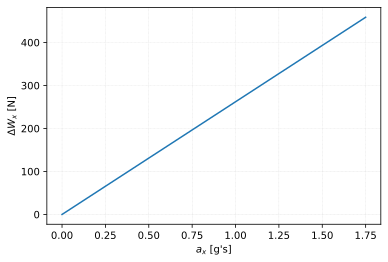

In [7]:
vehicle_input['L_1'] = vehicle_input['L_wheelbase'] * (1 - vehicle_input['rear_mass_distribution'])
vehicle_input['L_2'] = vehicle_input['L_wheelbase'] - vehicle_input['L_1']

DeltaW_x = pd.DataFrame()

W_total = int(vehicle_input['W_total'])
h_cg = int(vehicle_input['h_cg'])
L_wheelbase = int(vehicle_input['L_wheelbase'])

DeltaW_x['ax'] = np.arange(0,2,0.25)
DeltaW_x['load_transfer'] = DeltaW_x['ax'] * W_total * h_cg / L_wheelbase

fig =  plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot('ax', 'load_transfer', data = DeltaW_x)
ax.set_xlabel('$a_x$ [g\'s]')
ax.set_ylabel('$\Delta W_x$ [N]')
ax.grid(linestyle=':', linewidth=0.3)

For a given longitudinal aceleration there is a corresponding longitudinal weight transfer which compresses the rear spring and extends the front spring. Thus, the dual rate spring system can be related with the longitudinal acceleration by the given formula:

$
\begin{align}
a_x = \frac{FL_{wb}}{m h_{cg}}
\end{align}
$

In [8]:
spring_system['ax'] = spring_system['spring_force'] * L_wheelbase /  (W_total * h_cg * 9.81)

spring_system.head()

,displacement,spring_force,setup,ax
0,0.0,0.0,1,0.000000
1,0.1,2.3,1,0.000895
2,0.2,4.6,1,0.001789
3,0.3,6.9,1,0.002684
4,0.4,9.2,1,0.003579


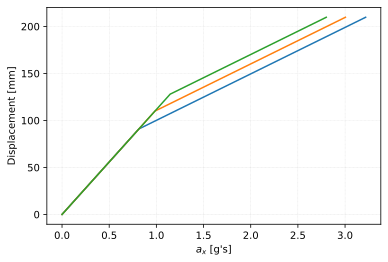

In [9]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(1,1,1)


for setup in range(1, len(spring_input) + 1):

    ax.plot('ax', 'displacement', data = spring_system[spring_system['setup']==setup])


    
#ax.legend()
ax.set_xlabel('$a_x$ [g\'s]')
ax.set_ylabel('Displacement [mm]')
ax.grid(linestyle=':', linewidth=0.3)